In [1]:
import numpy as np
import numpy.ma as ma
import pandas as pd
import datetime

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.ticker import MaxNLocator

import feather

from tqdm import tqdm_notebook as tqdm

from tqdm import tqdm_pandas

from scipy.sparse import csr_matrix
from pandas.api.types import CategoricalDtype

from multiprocessing import Pool

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from sklearn import preprocessing

from pathlib import Path

# import plaidml.keras

# plaidml.keras.install_backend()

import keras
from keras.preprocessing import sequence
from keras import layers, Input, Model
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, LSTM, Dropout

import tensorflow as tf

Using TensorFlow backend.


## Loading and setting up the data

In [49]:
se = feather.read_dataframe("../../data_files/B/once/75days/stop_events_with_geo_train_test_averages_prev_next_dwell.feather",
                            columns=["index",
                                     "segment_duration",
                                     "mean_durations_by_segment_code",
                                     "mean_durations_by_segment_code_and_hour_and_day",
                                     "diff_segment_and_mean_by_segment_code",
                                     "diff_segment_and_mean_by_segment_code_and_hour_and_day",
                                     'line_distance',
                                     'to_centre_dist',
                                     'direction_degrees',
                                     'rain',
                                     'median_durations_by_segment_code_and_hour_and_day',
                                     'arrival_hour','arrival_day',
                                     "diff_percent_segment_and_mean_by_segment_code_and_hour_and_day",
                                     'arrival_hour','arrival_day',
                                     "diff_percent_segment_and_mean_by_segment_code_and_hour_and_day",
                                     'date','workid',
                                     'actualArrival'
                                    ])
se = se.set_index(se.columns[0])

In [62]:
 # And now for just segments:
se["diff_segment_and_mean_by_segment_code"] = (
    se["segment_duration"]
    - se["mean_durations_by_segment_code"]
)
se["diff_segment_and_mean_by_segment_code_and_hour_and_day"] = (
    se["segment_duration"]
    - se["mean_durations_by_segment_code_and_hour_and_day"]
)

se["diff_percent_segment_and_mean_by_segment_code"] = (
    se["diff_segment_and_mean_by_segment_code"]
    * 100
    / se["mean_durations_by_segment_code"]
)

se["diff_percent_segment_and_mean_by_segment_code_and_hour_and_day"] = (
    se["diff_segment_and_mean_by_segment_code_and_hour_and_day"]
    * 100
    / se["mean_durations_by_segment_code_and_hour_and_day"]
)

## Settings

In [4]:
data_size = 2000000
data_mask = np.zeros(se.shape[0]).astype(bool)

data_mask[:data_size] = True

train = False
test = False

if train:
    data_mask = se['train']
    
if test: 
    data_mask = se['test']

data_size = np.count_nonzero(data_mask)


In [5]:
print(data_size)

2000000


In [6]:
test_matrix = np.load(f"percentage_offsets_check.npy").T

In [7]:
test_matrix.shape

(3920087, 2)

In [8]:
(test_matrix[:,0].astype(int)[500000:2000000] == se.index.values[500000:2000000]).all()

True

In [9]:
(test_matrix[data_mask,1] == se.loc[:,'diff_percent_segment_and_mean_by_segment_code_and_hour_and_day'][data_mask].values).all()


True

In [10]:
# test_length = np.count_nonzero(se['test'])

# test_mask = se['test']

In [ ]:
# 1st dimention is number of data points
# 2nd dimention is going back in time (in 10 min increments)
# 3rd dimention is prev-next segments

width_array = [
             'prev_segment_code_11',
             'prev_segment_code_10',
             'prev_segment_code_9',
             'prev_segment_code_8',
             'prev_segment_code_7',
             'prev_segment_code_6',
             'prev_segment_code_5', 
             'prev_segment_code_4', 
             'prev_segment_code_3', 
             'prev_segment_code_2', 
             'prev_segment_code_1', 
             'segment_code',
             'next_segment_code_1',
             'next_segment_code_2',
             'next_segment_code_3',
             'next_segment_code_4',
             'next_segment_code_5',
             'next_segment_code_6',
             'next_segment_code_7',
             'next_segment_code_8',
             'next_segment_code_9',
             'next_segment_code_10',
             'next_segment_code_11',
            ]

means = np.empty((data_size, 25, len(width_array))).astype(float)
counts = np.empty((data_size, 25, len(width_array))).astype(int)

index = np.empty((data_size)).astype(int)

for idx, code in enumerate(tqdm(width_array)):
    
    matrix = np.load(f"mtx_{code}_last_25_10_2nd.npy")
    
#     matrix = matrix[se.index.values[:np.argmax(se.index.values>=3920086)],:]
    

    means[:,:,idx] = matrix[data_mask,1:26].astype(float)
    counts[:,:,idx] = matrix[data_mask,26:].astype(int)
    
    if idx == 0:
        index = matrix[data_mask,0].astype(int)
            
#     print(".", end="", flush=True)
        
  
    

In [ ]:
# se = se[:np.argmax(se.index.values>=3920086)]

In [ ]:

print((index == se.index[data_mask]).all())


In [11]:
def calc_slice(width, time, width_offset=0, time_offset=0, additional_prev=0):
    centre = int(len(width_array)/2) + 1
    centre += width_offset
    
    return np.s_[:,2+time_offset:time+3+time_offset,centre-width-additional_prev:centre+width+1]


In [12]:
def calc_offsets(means, counts, slices, axis, column_name, mask_threshold):
    
    mask = np.sum(counts[slices], axis=axis) > mask_threshold
    
    threshold_pass_fraction = np.count_nonzero(mask)/len(mask)
    
    if  threshold_pass_fraction < 0.25:
        raise ValueError('not enough data passing threshold')
    
    print(f"Approximately {threshold_pass_fraction*100:0.2f}% pass the threshold")
    
    data = means[slices][mask]
    
    weights = counts[slices][mask]
    
    masked_data = np.ma.masked_array(data, np.isnan(data))
    
    if column_name is not None:    
        se[column_name] = 0

        se.loc[mask, column_name] = np.ma.average(masked_data, axis=axis, weights=weights)
        
        return
    
    offsets = np.zeros(counts.shape[0])
    
    offsets[mask] = np.ma.average(masked_data, axis=axis, weights=weights)
    
    return offsets, threshold_pass_fraction, np.mean(np.sum(weights, axis=axis))

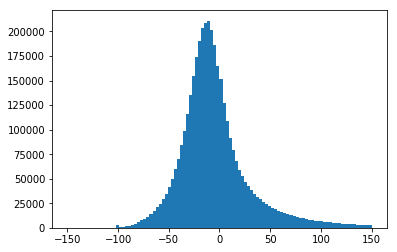

In [13]:
plt.hist(se['diff_percent_segment_and_mean_by_segment_code_and_hour_and_day'], bins=100, range=(-150,150));
# plt.hist(se['full_mean_minus_recent_15'], bins=100, range=(-150,150), alpha=0.5);

In [14]:
#Width of 2 and time of 100 with a threshold of 40

calc_slice(2,10)

bus_counts = np.sum(counts[calc_slice(2,10)], axis=(1,2))

dense_mask = (bus_counts>=40)

print(f"Fraction over 40: {(bus_counts>=40).sum()/bus_counts.shape[0]}")

NameError: name 'width_array' is not defined

In [ ]:
plt.hist(bus_counts, bins=20, range=(0,200), density=True);
plt.xlabel("Number of buses")
plt.ylabel("Fraction")
plt.title("Number of data points for last 220 mins (minus the most recent 20)\nincl 2 prev & 2 next segments")

In [ ]:
# 1st Dimension is length of data points
# 2nd dimension is going back in time
# 3rd dimention is prev-next

# Thoughts on the defaults:
# - Set to zero (fast but doesn't contain much data)
# - Set to v sparce prediction (probably better)
# - Try to predict diff between v sparse mean and truth, 
#              set empty to zero and values to diff from 
#              v sparse mean

# Other ideas:
# - When making the offsets going one stop further previous than next 
#              (as prev' seems to be a better predictor)
# - Try a stride length of 2 both in time and down the road
# - Try a little less dense...
st_offsets_dense = np.zeros((data_size, 11, 11))

for i in range(11):
    for j in range(-5,6,1):

        st_offsets_dense[:,i,j+3], _, _ = calc_offsets(means, counts, calc_slice(2,10,j,i), (1,2), None, 60)
        




In [ ]:
# 1st Dimension is length of data points
# 2nd dimension is going back in time
# 3rd dimention is prev-next


st_offsets_dense_plus_prev = np.zeros((data_size, 11, 11))

for i in range(11):
    for j in range(-5,6,1):

        st_offsets_dense_plus_prev[:,i,j+3], _, _ = calc_offsets(means, counts, calc_slice(2,10,j,i,1), (1,2), None, 60)
        





In [ ]:
offsets_sparse2, _, _ = calc_offsets(means, counts, calc_slice(10,20), (1,2), None, 40)

In [ ]:
offsets_dense2 = st_offsets_dense[:,0,5]

In [ ]:
np.save("bus_counts(2,10)", bus_counts)

In [ ]:
np.save("offsets_sparse2(10,20)", offsets_sparse2)

In [ ]:
np.save("st_offsets_dense(2,10)_t_off(0,11)_w_off(-5,6)", st_offsets_dense)

In [ ]:
np.save("st_offsets_dense(2,10)_t_off(0,11)_w_off(-5,6)_1prev", st_offsets_dense_plus_prev)

In [118]:
st_offsets_dense = np.load("st_offsets_dense(2,10)_t_off(0,11)_w_off(-5,6).npy")
bus_counts = np.load("bus_counts(2,10).npy")
offsets_sparse2 = np.load("offsets_sparse2(10,20).npy")
st_offsets_dense_plus_prev = np.load("st_offsets_dense(2,10)_t_off(0,11)_w_off(-5,6)_1prev.npy")
offsets_dense2 = st_offsets_dense[:,0,5]

In [16]:
# make a copy and then in that copy replace all zeros with the sparse prediction instead. 
# Technically there might be a few zeros that are actually valid means but the chance of 
# a mean being exactly zero is quite small. 

offsets_sparse2_big = np.empty(st_offsets_dense.shape)

offsets_sparse2_big[:] = offsets_sparse2[:,None,None]

st_offsets_dense_replaced = st_offsets_dense.copy()

st_offsets_dense_replaced[st_offsets_dense_replaced == 0] = offsets_sparse2_big[st_offsets_dense_replaced == 0]

st_offsets_dense_prev_replaced = st_offsets_dense_plus_prev.copy()

st_offsets_dense_prev_replaced[st_offsets_dense_prev_replaced == 0] = offsets_sparse2_big[st_offsets_dense_prev_replaced == 0]

offsets_sparse2_big = None


In [ ]:
np.count_nonzero(st_offsets_dense_replaced - st_offsets_dense)

In [ ]:
np.count_nonzero(st_offsets_dense_replaced - offsets_sparse2[:,None,None])/st_offsets_dense.size

In [17]:
def create_LSTM_large(input_shape, dropout, recurant_dropout):

    model = Sequential()

    # New Start
    model.add(LSTM(80, input_shape=input_shape, recurrent_dropout=recurant_dropout))

    # Old start
    # model.add(LSTM(40, input_shape=input_shape))
    model.add(layers.Dropout(rate=dropout))
    model.add(Dense(128, activation="relu"))
    model.add(layers.Dropout(rate=dropout))
    model.add(Dense(64, activation="relu"))
    model.add(layers.Dropout(rate=dropout))
    model.add(Dense(32, activation="relu"))
    model.add(layers.Dropout(rate=dropout))
    model.add(Dense(12, activation="relu"))
    model.add(layers.Dropout(rate=dropout))
    model.add(Dense(12, activation="relu"))
    model.add(layers.Dropout(rate=dropout))
    model.add(Dense(1, activation="tanh"))
    model.summary()

    return model

In [18]:
def create_combined_model(road_input_shape, aux_input_shape, dropout, recurant_dropout):

    # with help from: https://keras.io/getting-started/functional-api-guide/

    # Headline input: meant to receive road time series.
    main_input = Input(shape=road_input_shape, dtype="float32", name="road_time_input")
    lstm_out = LSTM(80, recurrent_dropout=recurant_dropout)(main_input)

    auxiliary_output = Dense(1, activation="tanh", name="aux_output")(lstm_out)

    auxiliary_input = Input(shape=(aux_input_shape,), name="aux_input")
    x = keras.layers.concatenate([lstm_out, auxiliary_input])

    # We stack a deep densely-connected network on top
    x = Dense(128, activation="relu")(x)
    x = Dropout(rate=dropout)(x)
    x = Dense(64, activation="relu")(x)
    x = Dropout(rate=dropout)(x)
    x = Dense(32, activation="relu")(x)
    x = Dropout(rate=dropout)(x)
    x = Dense(12, activation="relu")(x)
    x = Dropout(rate=dropout)(x)
    x = Dense(12, activation="relu")(x)
    x = Dropout(rate=dropout)(x)

    # And finally we add the main output layer
    main_output = Dense(1, activation="tanh", name="main_output")(x)

    model = Model(
        inputs=[main_input, auxiliary_input], outputs=[main_output, auxiliary_output]
    )

    model.summary()

    return model

In [85]:
def create_any_combined_model(road_input_shape, aux_input_shape, dropout, recurant_dropout, lstm_layers, dense_layers):

    # with help from: https://keras.io/getting-started/functional-api-guide/

    # Headline input: meant to receive road time series.
    main_input = Input(shape=road_input_shape, dtype="float32", name="road_time_input")
    
    for idx, layer in enumerate(lstm_layers):
        
        if idx == 0:
            lstm_out = LSTM(layer, recurrent_dropout=recurant_dropout, return_sequences=(idx+1 < len(lstm_layers)))(main_input)
        else:
            lstm_out = LSTM(layer, recurrent_dropout=recurant_dropout, return_sequences=(idx+1 < len(lstm_layers)))(lstm_out)
        

    auxiliary_output = Dense(1, activation="tanh", name="aux_output")(lstm_out)

    auxiliary_input = Input(shape=(aux_input_shape,), name="aux_input")
    x = keras.layers.concatenate([lstm_out, auxiliary_input])

    for layer in dense_layers:
        x = Dense(layer, activation="relu")(x)
        x = Dropout(rate=dropout)(x)

    # And finally we add the main output layer
    main_output = Dense(1, activation="tanh", name="main_output")(x)

    model = Model(
        inputs=[main_input, auxiliary_input], outputs=[main_output, auxiliary_output]
    )

    model.summary()

    return model

In [ ]:
(baseline_array_cum, 
 actual_array_cum, 
 baseline_median_array_cum, 
 baseline_pass_count, 
 pass_fraction, 
 baseline_median_pass_count, 
 median_pass_fraction) = calc_baseline_and_actual(test_mask)

In [60]:
aux_matrix = se[['line_distance',
                 'to_centre_dist','direction_degrees',
                 'rain',#'mean_durations_by_segment_code',
#                  'mean_durations_by_segment_code_and_hour_and_day',
#                  'median_durations_by_segment_code_and_hour_and_day',
                ]][data_mask].values

aux_matrix = np.hstack((aux_matrix, 
                        pd.get_dummies(se['arrival_hour'][data_mask]).values,
                      pd.get_dummies(se['arrival_day'][data_mask]).values,
                      bus_counts[:,None],
                       offsets_sparse2[:,None],
                       offsets_dense2[:,None]))

In [63]:
cut_point = int(data_size*3/4)

train_matrix_st_replaced = st_offsets_dense_replaced[:cut_point,:,:]
test_matrix_st_replaced = st_offsets_dense_replaced[cut_point:,:,:]

train_matrix_st = st_offsets_dense[:cut_point,:,:]
test_matrix_st = st_offsets_dense[cut_point:,:,:]

train_matrix_st_prev = st_offsets_dense_plus_prev[:cut_point,:,:]
test_matrix_st_prev = st_offsets_dense_plus_prev[cut_point:,:,:]

train_matrix_st_prev_replaced = st_offsets_dense_prev_replaced[:cut_point,:,:]
test_matrix_st_prev_replaced = st_offsets_dense_prev_replaced[cut_point:,:,:]

train_matrix_aux = aux_matrix[:cut_point,:]
test_matrix_aux = aux_matrix[cut_point:,:]

test_mask = np.zeros(data_size).astype(bool)
test_mask[cut_point:] = True

target = se.loc[data_mask, 'diff_percent_segment_and_mean_by_segment_code_and_hour_and_day'].values

train_target = target[:cut_point]
test_target = target[cut_point:]

scaler_target = preprocessing.StandardScaler().fit(train_target[:, None])

train_target_scaled = scaler_target.transform(train_target[:, None]).astype(np.float32)
test_target_scaled = scaler_target.transform(test_target[:, None]).astype(np.float32)

st_scaler = preprocessing.StandardScaler()
st_replaced_scaler = preprocessing.StandardScaler()
st_prev_scaler = preprocessing.StandardScaler()
st_prev_replaced_scaler = preprocessing.StandardScaler()
aux_scaler = preprocessing.StandardScaler()

train_matrix_st_shape = train_matrix_st.shape
test_matrix_st_shape = test_matrix_st.shape

train_matrix_st = st_scaler.fit_transform(
    train_matrix_st.reshape(-1,1)
).reshape(train_matrix_st_shape)

test_matrix_st = st_scaler.transform(
    test_matrix_st.reshape(-1,1)
).reshape(test_matrix_st_shape)

train_matrix_st_replaced = st_replaced_scaler.fit_transform(
    train_matrix_st_replaced.reshape(-1,1)
).reshape(train_matrix_st_shape)

test_matrix_st_replaced = st_replaced_scaler.transform(
    test_matrix_st_replaced.reshape(-1,1)
).reshape(test_matrix_st_shape)

train_matrix_st_prev = st_prev_scaler.fit_transform(
    train_matrix_st_prev.reshape(-1,1)
).reshape(train_matrix_st_shape)

test_matrix_st_prev = st_prev_scaler.transform(
    test_matrix_st_prev.reshape(-1,1)
).reshape(test_matrix_st_shape)

train_matrix_st_prev_replaced = st_prev_replaced_scaler.fit_transform(
    train_matrix_st_prev_replaced.reshape(-1,1)
).reshape(train_matrix_st_shape)

test_matrix_st_prev_replaced = st_prev_replaced_scaler.transform(
    test_matrix_st_prev_replaced.reshape(-1,1)
).reshape(test_matrix_st_shape)

train_matrix_aux = aux_scaler.fit_transform(train_matrix_aux)
test_matrix_aux = aux_scaler.transform(test_matrix_aux)



In [87]:
train_mtx = train_matrix_st_prev_replaced[:,:5,3:8]
test_mtx = test_matrix_st_prev_replaced[:,:5,3:8]

model = create_any_combined_model(
        (train_mtx.shape[1], train_mtx.shape[2]),
        train_matrix_aux.shape[1],
        0.1,
        0.1,
    [40,40],
    [64,32,32,32,12]
    )

Path(f"ST_models").mkdir(parents=True, exist_ok=True)

callbacks_list = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=2),
    keras.callbacks.ModelCheckpoint(
        filepath=f"ST_models/any_model_[40,40],[64,32,32,32,12].h5",
        monitor="val_loss",
        save_best_only=True,
    ),
]

# model.compile(optimizer="rmsprop", loss="mean_absolute_error")
model.compile(optimizer="rmsprop", loss="logcosh", loss_weights=[1, 0.25])
model.fit(
    [train_mtx,train_matrix_aux],
    [train_target_scaled, train_target_scaled],
    epochs=100,
    callbacks=callbacks_list,
    batch_size=512,
    validation_data=([test_mtx,test_matrix_aux], [test_target_scaled,test_target_scaled]),
)

test_y_scaled, _ = model.predict(test_matrix_st)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
road_time_input (InputLayer)    (None, 5, 5)         0                                            
__________________________________________________________________________________________________
lstm_11 (LSTM)                  (None, 5, 40)        7360        road_time_input[0][0]            
__________________________________________________________________________________________________
lstm_12 (LSTM)                  (None, 40)           12960       lstm_11[0][0]                    
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 34)           0                                            
__________________________________________________________________________________________________
concatenat

KeyboardInterrupt: 

In [66]:
model_to_load = 'ST_models/combined_run_0_dropout_0.0_0.0_huber_delta_1_iweights_0.0_matrix_prev_replaced_55_80_128_64_32_12_12_1.h5'

train_mtx = train_matrix_st_prev_replaced[:,:5,3:8]
test_mtx = test_matrix_st_prev_replaced[:,:5,3:8]
    
# Create the network and load the weights into it
model = create_combined_model(
        (train_mtx.shape[1], train_mtx.shape[2]),
        train_matrix_aux.shape[1],
        0.1,
        0.1,
    )

model.load_weights(model_to_load)

model.compile(optimizer="rmsprop", loss="logcosh")
test_y_scaled, _ = model.predict([test_mtx, test_matrix_aux])


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
road_time_input (InputLayer)    (None, 5, 5)         0                                            
__________________________________________________________________________________________________
lstm_8 (LSTM)                   (None, 80)           27520       road_time_input[0][0]            
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 34)           0                                            
__________________________________________________________________________________________________
concatenate_8 (Concatenate)     (None, 114)          0           lstm_8[0][0]                     
                                                                 aux_input[0][0]                  
__________

In [88]:
test_y = scaler_target.inverse_transform(test_y_scaled)

In [89]:
mean_absolute_error(test_target, test_y)

28.228550527479737

In [90]:
mean_absolute_error(test_target, st_offsets_dense[cut_point:,0,3])

30.047223401735707

In [91]:
mean_absolute_error(test_target, offsets_sparse2[cut_point:])

29.998359191835657

In [92]:
mean_absolute_error(test_target, [0] * len(test_target))

30.024624618099693

In [93]:
# offsets_dense2, _, mean_weights_dense2 = calc_offsets(means, counts, calc_slice(1,8), (1,2), None, 40)

# offsets_dense, _, mean_weights_dense = calc_offsets(means, counts, calc_slice(2,10), (1,2), None, 40)

# offsets_sparse, _, mean_weights_sparse = calc_offsets(means, counts, calc_slice(8,15), (1,2), None, 60)

# offsets_sparse2, _, mean_weights_sparse2 = calc_offsets(means, counts, calc_slice(10,20), (1,2), None, 40)



In [94]:
# target = se.loc[data_mask, 'diff_percent_segment_and_mean_by_segment_code_and_hour_and_day']

print(f"MAE dense2: {mean_absolute_error(test_target, st_offsets_dense[cut_point:,0,3])}")

print(f"MAE dense2_prev: {mean_absolute_error(test_target, st_offsets_dense[cut_point:,0,2])}")

print(f"MAE dense2_next: {mean_absolute_error(test_target, st_offsets_dense[cut_point:,0,4])}")
      
print(f"MAE sparse2: {mean_absolute_error(test_target, offsets_sparse2[cut_point:])}")
            
print(f"MAE RNN: {mean_absolute_error(test_target, test_y)}")
      
      

MAE dense2: 30.047223401735707
MAE dense2_prev: 30.03315964783844
MAE dense2_next: 30.05612684614677
MAE sparse2: 29.998359191835657
MAE RNN: 28.228550527479737


In [95]:
# target = se.loc[data_mask, 'diff_percent_segment_and_mean_by_segment_code_and_hour_and_day']

print(f"RMSE dense2: {np.sqrt(mean_squared_error(test_target, st_offsets_dense[cut_point:,0,3]))}")

print(f"RMSE dense2_prev: {np.sqrt(mean_squared_error(test_target, st_offsets_dense[cut_point:,0,2]))}")

print(f"RMSE dense2_next: {np.sqrt(mean_squared_error(test_target, st_offsets_dense[cut_point:,0,4]))}")
      
print(f"RMSE sparse2: {np.sqrt(mean_squared_error(test_target, offsets_sparse2[cut_point:]))}")
            
print(f"RMSE RNN: {np.sqrt(mean_squared_error(test_target, test_y))}")
      
# print(f"RMSE sparse2: {np.sqrt(mean_squared_error(target, offsets_sparse2))}")
      
      

RMSE dense2: 57.51393792370891
RMSE dense2_prev: 57.52724189078178
RMSE dense2_next: 57.52103593680372
RMSE sparse2: 57.51963372874016
RMSE RNN: 58.00554379622149


In [113]:
data_size

2000000

In [114]:
MAE_baseline = []
MAE_dense2_predict = []
# MAE_dense_predict = []
# MAE_sparse_predict = []
MAE_RNN_predict = []
MAE_sparse2_predict = []

RMSE_baseline = []
RMSE_dense2_predict = []
# RMSE_dense_predict = []
# RMSE_sparse_predict = []
RMSE_RNN_predict = []
RMSE_sparse2_predict = []

freqeuncy = []

x = np.array(range(20))*10

# target = se.loc[data_mask, 'diff_percent_segment_and_mean_by_segment_code_and_hour_and_day'].values[cut_point:]
baseline = np.zeros(data_size)

for i in x:


    full_mask = (bus_counts>i) & (bus_counts<i+10)
    
    freqeuncy.append(np.count_nonzero(full_mask))
    
    MAE_baseline.append(mean_absolute_error(target[full_mask], baseline[full_mask]))
    
    MAE_dense2_predict.append(mean_absolute_error(target[full_mask], offsets_dense2[full_mask]))
        
#     MAE_dense_predict.append(mean_absolute_error(target[full_mask], offsets_dense[full_mask]))
    
#     MAE_sparse_predict.append(mean_absolute_error(target[full_mask], offsets_sparse[full_mask]))

#     MAE_RNN_predict.append(mean_absolute_error(test_target[full_mask], test_y[full_mask]))
    
    MAE_sparse2_predict.append(mean_absolute_error(target[full_mask], offsets_sparse2[full_mask]))
    
    RMSE_baseline.append(mean_squared_error(target[full_mask], baseline[full_mask]))
    
    RMSE_dense2_predict.append(mean_squared_error(target[full_mask], offsets_dense2[full_mask]))
        
#     RMSE_dense_predict.append(mean_squared_error(target[full_mask], offsets_dense[full_mask]))
    
#     RMSE_sparse_predict.append(mean_squared_error(target[full_mask], offsets_sparse[full_mask]))

#     RMSE_RNN_predict.append(mean_squared_error(test_target[full_mask], test_y[full_mask]))
    
    RMSE_sparse2_predict.append(mean_squared_error(target[full_mask], offsets_sparse2[full_mask]))
    

In [96]:
MAE_baseline = []
MAE_dense2_predict = []
# MAE_dense_predict = []
# MAE_sparse_predict = []
MAE_RNN_predict = []
MAE_sparse2_predict = []

RMSE_baseline = []
RMSE_dense2_predict = []
# RMSE_dense_predict = []
# RMSE_sparse_predict = []
RMSE_RNN_predict = []
RMSE_sparse2_predict = []



freqeuncy = []

x = np.array(range(20))*10

# target = se.loc[data_mask, 'diff_percent_segment_and_mean_by_segment_code_and_hour_and_day'].values[cut_point:]
baseline = np.zeros(data_size)[cut_point:]

for i in x:


    full_mask = (bus_counts>i)[cut_point:] & (bus_counts<i+10)[cut_point:]
    
    freqeuncy.append(np.count_nonzero(full_mask))
    
    MAE_baseline.append(mean_absolute_error(test_target[full_mask], baseline[full_mask]))
    
    MAE_dense2_predict.append(mean_absolute_error(test_target[full_mask], st_offsets_dense[cut_point:,0,3][full_mask]))
        
#     MAE_dense_predict.append(mean_absolute_error(target[full_mask], offsets_dense[full_mask]))
    
#     MAE_sparse_predict.append(mean_absolute_error(target[full_mask], offsets_sparse[full_mask]))

    MAE_RNN_predict.append(mean_absolute_error(test_target[full_mask], test_y[full_mask]))
    
    MAE_sparse2_predict.append(mean_absolute_error(test_target[full_mask], offsets_sparse2[cut_point:][full_mask]))
    
    RMSE_baseline.append(mean_squared_error(test_target[full_mask], baseline[full_mask]))
    
    RMSE_dense2_predict.append(mean_squared_error(test_target[full_mask], st_offsets_dense[cut_point:,0,3][full_mask]))
        
#     RMSE_dense_predict.append(mean_squared_error(target[full_mask], offsets_dense[full_mask]))
    
#     RMSE_sparse_predict.append(mean_squared_error(target[full_mask], offsets_sparse[full_mask]))

    RMSE_RNN_predict.append(mean_squared_error(test_target[full_mask], test_y[full_mask]))
    
    RMSE_sparse2_predict.append(mean_squared_error(test_target[full_mask], offsets_sparse2[cut_point:][full_mask]))
    

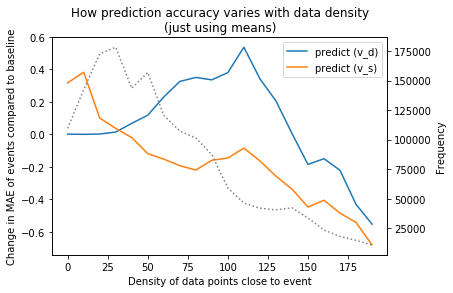

In [115]:
# MAE_dense_predict = np.array(MAE_dense_predict)
MAE_dense2_predict = np.array(MAE_dense2_predict)
MAE_baseline = np.array(MAE_baseline)
# MAE_sparse_predict = np.array(MAE_sparse_predict)
MAE_sparse2_predict = np.array(MAE_sparse2_predict)
# MAE_RNN_predict = np.array(MAE_RNN_predict)


# plt.plot(x, percentages_baseline, label="baseline")
# plt.plot(x, MAE_dense_predict-MAE_baseline, label="predict (d)")
plt.plot(x, MAE_dense2_predict-MAE_baseline, label="predict (v_d)")
# plt.plot(x, MAE_sparse_predict-MAE_baseline, label="predict (s)")
plt.plot(x, MAE_sparse2_predict-MAE_baseline, label="predict (v_s)")
# plt.plot(x, MAE_RNN_predict-MAE_baseline, label="RNN")

plt.xlabel("Density of data points close to event")
plt.ylabel("Change in MAE of events compared to baseline")
plt.legend(loc=1)
# plt.ylim(35,47)

ax = plt.gca()

ax2 = ax.twinx()
 
ax2.plot(x, freqeuncy, c="grey", ls=":")
# ax2.set_yscale("log")
ax2.set_ylabel("Frequency")
plt.title("How prediction accuracy varies with data density\n(just using means)")
# plt.savefig("accuracy vs density_2m_forward.pdf")
plt.show()



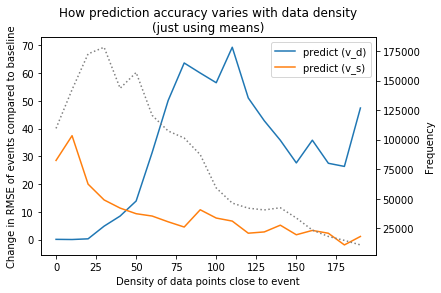

In [116]:
# RMSE_dense_predict = np.array(RMSE_dense_predict)
RMSE_dense2_predict = np.array(RMSE_dense2_predict)
RMSE_baseline = np.array(RMSE_baseline)
# RMSE_sparse_predict = np.array(RMSE_sparse_predict)
RMSE_sparse2_predict = np.array(RMSE_sparse2_predict)
# RMSE_RNN_predict = np.array(RMSE_RNN_predict)


# plt.plot(x, percentages_baseline, label="mean")
# plt.plot(x, RMSE_dense_predict-RMSE_baseline, label="predict (d)")
plt.plot(x, RMSE_dense2_predict-RMSE_baseline, label="predict (v_d)")
# plt.plot(x, RMSE_sparse_predict-RMSE_baseline, label="predict (s)")
plt.plot(x, RMSE_sparse2_predict-RMSE_baseline, label="predict (v_s)")
# plt.plot(x, RMSE_RNN_predict-RMSE_baseline, label="RNN")
plt.xlabel("Density of data points close to event")
plt.ylabel("Change in RMSE of events compared to baseline")
plt.legend(loc=1)
# plt.ylim(35,47)

ax = plt.gca()

ax2 = ax.twinx()
 
ax2.plot(x, freqeuncy, c="grey", ls=":")
ax2.set_ylabel("Frequency")
plt.title("How prediction accuracy varies with data density\n(just using means)")
# plt.savefig("accuracy vs density_2m_forward.pdf")
plt.show()



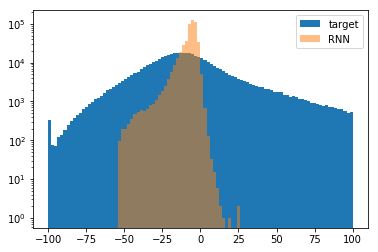

In [99]:
plt.hist(test_target, bins=100, range=(-100,100), label="target");
plt.hist(test_y, bins=100, range=(-100,100), alpha=0.5, label="RNN");
# plt.hist(st_offsets_dense[cut_point:,0,3], bins=100, range=(-100,100), alpha=0.5, label="Dense");
# plt.hist(offsets_sparse2[cut_point:], bins=100, range=(-100,100), alpha=0.5, label="Sparse");
plt.legend()
plt.yscale("log")


/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in less


In [100]:
predict_array_RNN_cum, _, pass_fraction = calc_prediction_cum_journeys(offsets=test_y.squeeze(), baseline_array_cum=baseline_array_cum, actual_array_cum=actual_array_cum, calc_mask=test_mask)


/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in less


Approximately 11.42% improvment on baseline
Approximately 44.46% are in 10%


In [101]:
# show_accuracy_minutes(predict_array_RNN_cum, actual_array_cum, title="RNN")

................................................................

KeyboardInterrupt: 

In [ ]:
# show_accuracy_minutes(baseline_array_cum, actual_array_cum, title="Baseline")

In [102]:
# show_accuracy_minutes(baseline_median_array_cum, actual_array_cum, title="Baseline Median")

....................................................................................................................................................................................................................................................................................................................

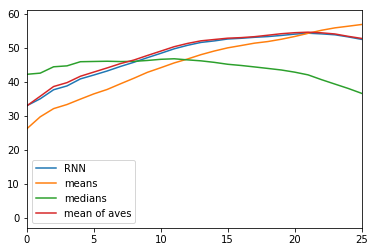

In [103]:
plt.plot(make_accuracy_matrix_minutes(predict_array_RNN_cum, actual_array_cum)[0][0,:], label="RNN")
plt.plot(make_accuracy_matrix_minutes(baseline_array_cum, actual_array_cum)[0][0,:], label="means")
plt.plot(make_accuracy_matrix_minutes(baseline_median_array_cum, actual_array_cum)[0][0,:], label="medians")
plt.plot(make_accuracy_matrix_minutes((baseline_median_array_cum + baseline_array_cum)/2, actual_array_cum)[0][0,:], label="mean of aves")
plt.xlim(0,25)
plt.legend()
plt.show()

In [44]:
median_pass_fraction

0.4515549435528691

In [ ]:
def full_test(dropout, rdropout, loss, filename, replaced=False):
    
    model = create_LSTM_large(
        (train_matrix_st.shape[1], train_matrix_st.shape[2]),
        dropout,
        rdropout,
    )

    Path(f"ST_models").mkdir(parents=True, exist_ok=True)

    callbacks_list = [
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=2),
        keras.callbacks.ModelCheckpoint(
            filepath=f"ST_models/" + filename,
            monitor="val_loss",
            save_best_only=True,
        ),
    ]

    # model.compile(optimizer="rmsprop", loss="mean_absolute_error")
    model.compile(optimizer="rmsprop", loss=loss)

    
    if replaced:
        model.fit(
            train_matrix_st_replaced,
            train_target_scaled,
            epochs=100,
            callbacks=callbacks_list,
            batch_size=64,
            validation_data=(test_matrix_st_replaced, test_target_scaled),
        )        
        
        test_y_scaled = model.predict(test_matrix_st_replaced)
    else:
        model.fit(
            train_matrix_st,
            train_target_scaled,
            epochs=100,
            callbacks=callbacks_list,
            batch_size=64,
            validation_data=(test_matrix_st, test_target_scaled),
        )

        test_y_scaled = model.predict(test_matrix_st)
    
    test_y = scaler_target.inverse_transform(test_y_scaled)
    
    print(f"MAE RNN: {mean_absolute_error(test_target, test_y)}")
    print(f"RMSE RNN: {np.sqrt(mean_squared_error(test_target, test_y))}")
    
    predict_array_RNN_cum, _, pass_fraction = calc_prediction_cum_journeys(offsets=test_y.squeeze(), baseline_array_cum=test_baseline_array_cum, actual_array_cum=test_actual_array_cum, calc_mask=test_mask)
    
    return pass_fraction, mean_absolute_error(test_target, test_y), np.sqrt(mean_squared_error(test_target, test_y))

In [53]:
train_matrix_st_prev_replaced[:,:5,3:8].shape

(1500000, 5, 5)

In [108]:
def full_test_combined(dropout, rdropout, loss, filename, delta, intermediate_weight, matrix, lstm_shape, dense_shape):
    
    if matrix == "st":
        train_mtx = train_matrix_st
        test_mtx = test_matrix_st
        
    if matrix == "replaced":
        train_mtx = train_matrix_st_replaced
        test_mtx = test_matrix_st_replaced
        
    if matrix == "prev":
        train_mtx = train_matrix_st_prev
        test_mtx = test_matrix_st_prev
        
    if matrix == "prev_replaced":
        train_mtx = train_matrix_st_prev_replaced
        test_mtx = test_matrix_st_prev_replaced
        
    if matrix == "prev_replaced_55":
        train_mtx = train_matrix_st_prev_replaced[:,:5,3:8]
        test_mtx = test_matrix_st_prev_replaced[:,:5,3:8]
        
        
    model = create_any_combined_model(
        (train_mtx.shape[1], train_mtx.shape[2]),
        train_matrix_aux.shape[1],
        dropout,
        rdropout,
        lstm_shape,
        dense_shape
    )

    Path(f"ST_models").mkdir(parents=True, exist_ok=True)

    callbacks_list = [
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=2),
        keras.callbacks.ModelCheckpoint(
            filepath=f"ST_models/" + filename,
            monitor="val_loss",
            save_best_only=True,
        ),
    ]
    
    delta = tf.cast(delta,tf.float32)
    
    def huber_loss(y_true, y_pred):
        return tf.losses.huber_loss(y_true,y_pred, delta=delta)

    if loss == 'huber':
        model.compile(optimizer="rmsprop", 
                      loss=huber_loss, 
                      loss_weights=[1, intermediate_weight])
    else:
        model.compile(optimizer="rmsprop", 
                      loss=loss, 
                      loss_weights=[1, intermediate_weight])
        
    
    model.fit(
        [train_mtx,train_matrix_aux],
        [train_target_scaled, train_target_scaled],
        epochs=100,
        callbacks=callbacks_list,
        batch_size=512,
        validation_data=([test_mtx, test_matrix_aux],
        [test_target_scaled, test_target_scaled],),
    )

    test_y_scaled, _ = model.predict([test_mtx, test_matrix_aux])
    
    test_y = scaler_target.inverse_transform(test_y_scaled)
    
    print(f"MAE RNN: {mean_absolute_error(test_target, test_y)}")
    print(f"RMSE RNN: {np.sqrt(mean_squared_error(test_target, test_y))}")
    
    predict_array_RNN_cum, _, pass_fraction = calc_prediction_cum_journeys(offsets=test_y.squeeze(), baseline_array_cum=baseline_array_cum, actual_array_cum=actual_array_cum, calc_mask=test_mask)
    
    return pass_fraction, mean_absolute_error(test_target, test_y), np.sqrt(mean_squared_error(test_target, test_y))

In [110]:
with open("combined_test4_5x4_no_aves.csv", "a+") as f: 
#     f.write("dropout,rdropout,loss,matrix,delta,intermediate_weight,lstm_shape,dense_shape,pass_fraction,MSE,RMSE\n")
    f.flush()
    for runs in range(5):
        for i in np.linspace(0,.3,3):
            for j in np.linspace(0,.3,3):
                for i_weight in np.linspace(0,1,3):
                    for loss in ['huber','logcosh']:
                        for matrix in ["prev_replaced_55"]: #, "prev_replaced","st", "replaced", "prev"]:
                            for lstm_shape in [[20,20,20],[40,40],[80]]:
                                for dense_shape in [[32,32,12],[64,32,12],[128,128,64,64,32,32]]:
                                    
                                    lstm_shape_s = "_".join(map(str,lstm_shape))
                                    dense_shape_s = '_'.join(map(str,dense_shape))
                            
                                    pass_frac, MSE, RMSE = full_test_combined(i, j, loss, f"combined_run_{runs}_dropout_{i}_{j}_{loss}_delta_1_iweights_{i_weight}_matrix_{matrix}_l_{lstm_shape_s}_d_{dense_shape_s}.h5", 1, i_weight, matrix, lstm_shape, dense_shape)
                                    f.write(f"{i},{j},{loss},{matrix},1,{i_weight},{lstm_shape_s},{dense_shape_s},{pass_frac},{MSE},{RMSE}\n") 
                                    f.flush()





__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
road_time_input (InputLayer)    (None, 5, 5)         0                                            
__________________________________________________________________________________________________
lstm_66 (LSTM)                  (None, 5, 20)        2080        road_time_input[0][0]            
__________________________________________________________________________________________________
lstm_67 (LSTM)                  (None, 5, 20)        3280        lstm_66[0][0]                    
__________________________________________________________________________________________________
lstm_68 (LSTM)                  (None, 20)           3280        lstm_67[0][0]                    
__________________________________________________________________________________________________
aux_input 

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in less


Approximately 10.63% improvment on baseline
Approximately 44.15% are in 10%
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
road_time_input (InputLayer)    (None, 5, 5)         0                                            
__________________________________________________________________________________________________
lstm_69 (LSTM)                  (None, 5, 20)        2080        road_time_input[0][0]            
__________________________________________________________________________________________________
lstm_70 (LSTM)                  (None, 5, 20)        3280        lstm_69[0][0]                    
__________________________________________________________________________________________________
lstm_71 (LSTM)                  (None, 20)           3280        lstm_70[0][0]                    
_________________________________

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in less


Approximately 11.37% improvment on baseline
Approximately 44.45% are in 10%
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
road_time_input (InputLayer)    (None, 5, 5)         0                                            
__________________________________________________________________________________________________
lstm_72 (LSTM)                  (None, 5, 20)        2080        road_time_input[0][0]            
__________________________________________________________________________________________________
lstm_73 (LSTM)                  (None, 5, 20)        3280        lstm_72[0][0]                    
__________________________________________________________________________________________________
lstm_74 (LSTM)                  (None, 20)           3280        lstm_73[0][0]                    
_________________________________

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in less


Approximately 11.02% improvment on baseline
Approximately 44.30% are in 10%
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
road_time_input (InputLayer)    (None, 5, 5)         0                                            
__________________________________________________________________________________________________
lstm_75 (LSTM)                  (None, 5, 40)        7360        road_time_input[0][0]            
__________________________________________________________________________________________________
lstm_76 (LSTM)                  (None, 40)           12960       lstm_75[0][0]                    
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 34)           0                                            
_________________________________

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in less


Approximately 10.77% improvment on baseline
Approximately 44.21% are in 10%
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
road_time_input (InputLayer)    (None, 5, 5)         0                                            
__________________________________________________________________________________________________
lstm_77 (LSTM)                  (None, 5, 40)        7360        road_time_input[0][0]            
__________________________________________________________________________________________________
lstm_78 (LSTM)                  (None, 40)           12960       lstm_77[0][0]                    
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 34)           0                                            
_________________________________

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in less


Approximately 11.40% improvment on baseline
Approximately 44.46% are in 10%
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
road_time_input (InputLayer)    (None, 5, 5)         0                                            
__________________________________________________________________________________________________
lstm_79 (LSTM)                  (None, 5, 40)        7360        road_time_input[0][0]            
__________________________________________________________________________________________________
lstm_80 (LSTM)                  (None, 40)           12960       lstm_79[0][0]                    
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 34)           0                                            
_________________________________

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in less


Approximately 11.49% improvment on baseline
Approximately 44.49% are in 10%
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
road_time_input (InputLayer)    (None, 5, 5)         0                                            
__________________________________________________________________________________________________
lstm_81 (LSTM)                  (None, 80)           27520       road_time_input[0][0]            
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 34)           0                                            
__________________________________________________________________________________________________
concatenate_43 (Concatenate)    (None, 114)          0           lstm_81[0][0]                    
                                 

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in less


Approximately 10.70% improvment on baseline
Approximately 44.18% are in 10%
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
road_time_input (InputLayer)    (None, 5, 5)         0                                            
__________________________________________________________________________________________________
lstm_82 (LSTM)                  (None, 80)           27520       road_time_input[0][0]            
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 34)           0                                            
__________________________________________________________________________________________________
concatenate_44 (Concatenate)    (None, 114)          0           lstm_82[0][0]                    
                                 

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in less


Approximately 11.71% improvment on baseline
Approximately 44.58% are in 10%
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
road_time_input (InputLayer)    (None, 5, 5)         0                                            
__________________________________________________________________________________________________
lstm_83 (LSTM)                  (None, 80)           27520       road_time_input[0][0]            
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 34)           0                                            
__________________________________________________________________________________________________
concatenate_45 (Concatenate)    (None, 114)          0           lstm_83[0][0]                    
                                 

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in less


Approximately 11.21% improvment on baseline
Approximately 44.38% are in 10%
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
road_time_input (InputLayer)    (None, 5, 5)         0                                            
__________________________________________________________________________________________________
lstm_84 (LSTM)                  (None, 5, 20)        2080        road_time_input[0][0]            
__________________________________________________________________________________________________
lstm_85 (LSTM)                  (None, 5, 20)        3280        lstm_84[0][0]                    
__________________________________________________________________________________________________
lstm_86 (LSTM)                  (None, 20)           3280        lstm_85[0][0]                    
_________________________________

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in less


Approximately 9.77% improvment on baseline
Approximately 43.81% are in 10%
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
road_time_input (InputLayer)    (None, 5, 5)         0                                            
__________________________________________________________________________________________________
lstm_87 (LSTM)                  (None, 5, 20)        2080        road_time_input[0][0]            
__________________________________________________________________________________________________
lstm_88 (LSTM)                  (None, 5, 20)        3280        lstm_87[0][0]                    
__________________________________________________________________________________________________
lstm_89 (LSTM)                  (None, 20)           3280        lstm_88[0][0]                    
__________________________________

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in less


Approximately 10.64% improvment on baseline
Approximately 44.15% are in 10%
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
road_time_input (InputLayer)    (None, 5, 5)         0                                            
__________________________________________________________________________________________________
lstm_90 (LSTM)                  (None, 5, 20)        2080        road_time_input[0][0]            
__________________________________________________________________________________________________
lstm_91 (LSTM)                  (None, 5, 20)        3280        lstm_90[0][0]                    
__________________________________________________________________________________________________
lstm_92 (LSTM)                  (None, 20)           3280        lstm_91[0][0]                    
_________________________________

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in less


Approximately 9.45% improvment on baseline
Approximately 43.68% are in 10%
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
road_time_input (InputLayer)    (None, 5, 5)         0                                            
__________________________________________________________________________________________________
lstm_93 (LSTM)                  (None, 5, 40)        7360        road_time_input[0][0]            
__________________________________________________________________________________________________
lstm_94 (LSTM)                  (None, 40)           12960       lstm_93[0][0]                    
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 34)           0                                            
__________________________________

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in less


Approximately 11.43% improvment on baseline
Approximately 44.47% are in 10%
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
road_time_input (InputLayer)    (None, 5, 5)         0                                            
__________________________________________________________________________________________________
lstm_95 (LSTM)                  (None, 5, 40)        7360        road_time_input[0][0]            
__________________________________________________________________________________________________
lstm_96 (LSTM)                  (None, 40)           12960       lstm_95[0][0]                    
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 34)           0                                            
_________________________________

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in less


Approximately 11.22% improvment on baseline
Approximately 44.39% are in 10%
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
road_time_input (InputLayer)    (None, 5, 5)         0                                            
__________________________________________________________________________________________________
lstm_97 (LSTM)                  (None, 5, 40)        7360        road_time_input[0][0]            
__________________________________________________________________________________________________
lstm_98 (LSTM)                  (None, 40)           12960       lstm_97[0][0]                    
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 34)           0                                            
_________________________________

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in less


Approximately 11.46% improvment on baseline
Approximately 44.48% are in 10%
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
road_time_input (InputLayer)    (None, 5, 5)         0                                            
__________________________________________________________________________________________________
lstm_99 (LSTM)                  (None, 80)           27520       road_time_input[0][0]            
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 34)           0                                            
__________________________________________________________________________________________________
concatenate_52 (Concatenate)    (None, 114)          0           lstm_99[0][0]                    
                                 

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in less


Approximately 11.41% improvment on baseline
Approximately 44.46% are in 10%
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
road_time_input (InputLayer)    (None, 5, 5)         0                                            
__________________________________________________________________________________________________
lstm_100 (LSTM)                 (None, 80)           27520       road_time_input[0][0]            
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 34)           0                                            
__________________________________________________________________________________________________
concatenate_53 (Concatenate)    (None, 114)          0           lstm_100[0][0]                   
                                 

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in less


Approximately 11.12% improvment on baseline
Approximately 44.34% are in 10%
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
road_time_input (InputLayer)    (None, 5, 5)         0                                            
__________________________________________________________________________________________________
lstm_101 (LSTM)                 (None, 80)           27520       road_time_input[0][0]            
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 34)           0                                            
__________________________________________________________________________________________________
concatenate_54 (Concatenate)    (None, 114)          0           lstm_101[0][0]                   
                                 

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in less


Approximately 10.43% improvment on baseline
Approximately 44.07% are in 10%
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
road_time_input (InputLayer)    (None, 5, 5)         0                                            
__________________________________________________________________________________________________
lstm_102 (LSTM)                 (None, 5, 20)        2080        road_time_input[0][0]            
__________________________________________________________________________________________________
lstm_103 (LSTM)                 (None, 5, 20)        3280        lstm_102[0][0]                   
__________________________________________________________________________________________________
lstm_104 (LSTM)                 (None, 20)           3280        lstm_103[0][0]                   
_________________________________

KeyboardInterrupt: 

In [ ]:
with open("combined_test2_11x11.csv", "a+") as f: 
    f.write("dropout,rdropout,loss,matrix,delta,intermediate_weight,pass_fraction,MSE,RMSE\n")
    for runs in range(5):
        for i in np.linspace(0.1,.3,3):
            for j in np.linspace(0.1,.3,3):
                for i_weight in np.linspace(0,1,3):
                    for loss in ['huber','logcosh']:
                        for matrix in ["st", "replaced", "prev"]:
                            
                            if loss == 'huber':
                                for delta in np.linspace(0.5,1.5,3):
                                    pass_frac, MSE, RMSE = full_test_combined(i, j, loss, f"combined_run_{runs}_dropout_{i}_{j}_{loss}_delta_{delta}_iweights_{i_weight}_matrix_{matrix}_80_128_64_32_12_12_1.h5", delta=delta, intermediate_weight=i_weight, matrix=matrix)
                                    f.write(f"{i},{j},{loss},{replaced},{delta},{i_weight},{pass_frac},{MSE},{RMSE}\n")
                                    f.flush()
                            else:
                                pass_frac, MSE, RMSE = full_test_combined(i, j, loss, f"combined_run_{runs}_dropout_{i}_{j}_{loss}_iweights_{i_weight}_matrix_{matrix}_80_128_64_32_12_12_1.h5", delta=1, intermediate_weight=i_weight, matrix=matrix)
                                f.write(f"{i},{j},{loss},{replaced},1,{i_weight},{pass_frac},{MSE},{RMSE}\n") 
                                f.flush()




In [ ]:
show_accuracy_minutes(predict_array_RNN_cum, actual_array_cum, "means")

In [35]:
def percent_in_x_percent(predict, actual, threshold):
    
    if np.count_nonzero(~np.isnan(actual)) == 0:
        return 0, 0
    
    threshold = threshold/100
    
    mask = (~np.isnan(predict) & ~np.isnan(actual))
    
    pass_count = np.count_nonzero((predict[mask] < actual[mask] * (1 + threshold)) & (predict[mask] > actual[mask] * (1-threshold)))
    
    over_count = np.count_nonzero(predict[mask] > actual[mask] * (1+threshold))
    
    under_count = np.count_nonzero(predict[mask] < actual[mask] * (1-threshold))
    
    pass_percent = pass_count/np.count_nonzero(mask) * 100
    
    if over_count + under_count == 0:
        drift = 0.5
    else:
        drift = over_count / (over_count + under_count)
    
    return pass_percent, drift

def make_accuracy_matrix_minutes(predict, actual, max_threshold = 50):

    actual_ints = np.array(actual/60).astype(int)
    
    rows = int(max_threshold/10)
    
    max_a = np.nanmax(actual)/60

    accuracies_table = np.empty((rows, int(max_a)))
    drift_table = np.empty((rows, int(max_a)))
    frequency = np.empty(int(max_a))

    for i in range(int(max_a)):
        print(".", end="", flush=True)
        mask = (actual_ints == i)
        
        frequency[i] = np.count_nonzero(mask)
        
        for j in range(1, rows+1):
            accuracy, drift = percent_in_x_percent(predict[mask], actual[mask], j * 10)
            accuracies_table[j-1,i] = accuracy
            drift_table[j-1, i] = drift

    return accuracies_table, frequency, drift_table

def show_accuracy_minutes(predict, actual, title):
    results, frequency, drift = make_accuracy_matrix_minutes(predict, actual)
    
    for i in range(results.shape[0]):
        plt.plot(results[i,:], label=f"{(i+1)*10}%")
        
        
    plt.xlabel("minutes ahead")
    plt.ylabel("percentage within threshold")
    plt.legend()
    plt.title(title)
    plt.xlim(0,20)
    plt.ylim(0,100)
    plt.gca().yaxis.grid(True, linewidth="0.2")
    
    ax = plt.gca()
    
    ax2 = ax.twinx()
    ax2.plot(drift[0,:], label="fraction over", linestyle=":")
    ax2.set_ylim(0,1)
   
    plt.show()

In [36]:
# From: https://stackoverflow.com/questions/51597849/padding-a-numpy-array-with-offsets-for-each-data-column

def create_padded_array(a, row_start, n_rows):
    r = np.arange(n_rows)[:,None]
    row_start = np.asarray(row_start)
    mask = (r >= row_start) & (r < row_start+a.shape[0])

    out = np.zeros(mask.shape, dtype=a.dtype)
    out[:] = np.nan
    out.T[mask.T] = a.ravel('F')
    return out   

def create_triangle(input_array, max_width=70):
    
    filled_values = np.empty((input_array.shape[0],70)).astype(float)
    
    filled_values[:] = input_array[:,None]
    
    return create_padded_array(filled_values, list(range(70)), input_array.shape[0]+71)[:input_array.shape[0],:]
    
    
    

In [37]:
def calc_baseline_and_actual(calc_mask):
    
    if len(calc_mask) == len(data_mask):
        se_min = se[data_mask].copy()
    else:
        se_min = se[data_mask][calc_mask].copy()
    
    baseline_array = np.empty((se_min.shape[0],70)).astype(float)
    baseline_array[:] = np.nan
    
    actual_array = np.empty((se_min.shape[0],70)).astype(float)
    actual_array[:] = np.nan
    
    baseline_median_array = np.empty((se_min.shape[0],70)).astype(float)
    baseline_median_array[:] = np.nan
    
    se_min = se_min.reset_index(drop=True)
    
    runs = se_min.groupby(['date','workid'])
    
    actual_index = se_min.columns.get_loc("segment_duration")
    baseline_index = se_min.columns.get_loc("mean_durations_by_segment_code_and_hour_and_day")
    baseline_median_index = se_min.columns.get_loc("median_durations_by_segment_code_and_hour_and_day")

    for name, run in runs:
        run = run.sort_values("actualArrival")
        
        baseline_array[run.index,:] = create_triangle(run.iloc[:, baseline_index])
        actual_array[run.index,:] = create_triangle(run.iloc[:, actual_index])
        baseline_median_array[run.index,:] = create_triangle(run.iloc[:, baseline_median_index])

#         run_length = len(run)

#         for i in range(min([run_length, 70])):
 
#             baseline_array[run.iloc[i:].index,i] = run.iloc[:run_length-i, baseline_index]

#             actual_array[run.iloc[i:].index,i] = run.iloc[:run_length-i, actual_index]
            
    baseline_array_cum = np.cumsum(baseline_array, axis=1)
    actual_array_cum = np.cumsum(actual_array, axis=1)
    baseline_median_array_cum = np.cumsum(baseline_median_array, axis=1)
    
    actual_array_cum = np.clip(actual_array_cum, 0, 2*60*60)
    
    first_20mins_mask = actual_array_cum < 20*60
    
    baseline_pass_count = np.count_nonzero((baseline_array_cum[first_20mins_mask] < actual_array_cum[first_20mins_mask] * 1.1) & \
                    (baseline_array_cum[first_20mins_mask] > actual_array_cum[first_20mins_mask] * 0.9))
    
    pass_fraction = baseline_pass_count/np.count_nonzero(first_20mins_mask)
    
    baseline_median_pass_count = np.count_nonzero((baseline_median_array_cum[first_20mins_mask] < actual_array_cum[first_20mins_mask] * 1.1) & \
                    (baseline_median_array_cum[first_20mins_mask] > actual_array_cum[first_20mins_mask] * 0.9))
    
    median_pass_fraction = baseline_median_pass_count/np.count_nonzero(first_20mins_mask)
    
    return baseline_array_cum, actual_array_cum, baseline_median_array_cum, baseline_pass_count, pass_fraction, baseline_median_pass_count, median_pass_fraction


In [ ]:
baseline_array_cum, actual_array_cum, baseline_pass_count = calc_baseline_and_actual(data_mask)

In [39]:
def calc_prediction_cum_journeys(column_name=None, offsets=None, baseline_array_cum=baseline_array_cum, actual_array_cum=actual_array_cum, calc_mask=data_mask):
    
    if len(calc_mask) == len(data_mask):
        se_min = se[data_mask].copy()
    else:
        se_min = se[data_mask][calc_mask].copy()
    
    if column_name is not None:
        se_min['prediction'] = se_min['mean_durations_by_segment_code_and_hour_and_day'] * (1 + (se_min[column_name]/100))
    
    if offsets is not None:
        se_min['prediction'] = se_min['mean_durations_by_segment_code_and_hour_and_day'] * (1 + (offsets.squeeze()/100))
    
    predict_array = np.empty((se_min.shape[0],70)).astype(float)
    predict_array[:] = np.nan
    
    se_min = se_min.reset_index(drop=True)
    
    runs = se_min.groupby(['date','workid'])
    
    prediction_index = se_min.columns.get_loc("prediction")
    
    for name, run in runs:
        run = run.sort_values("actualArrival")
        
        predict_array[run.index,:] = create_triangle(run.iloc[:, prediction_index])

#         run_length = len(run)

#         for i in range(min([run_length, 70])):

#             predict_array[run.iloc[i:].index,i] = run.iloc[:run_length-i, prediction_index]
            
    predict_array_cum = np.cumsum(predict_array, axis=1)
    
    first_20mins_mask = actual_array_cum < 20*60
    
    baseline_pass_count = np.count_nonzero((baseline_array_cum[first_20mins_mask] < actual_array_cum[first_20mins_mask] * 1.1) & \
                    (baseline_array_cum[first_20mins_mask] > actual_array_cum[first_20mins_mask] * 0.9))
    
    
    pass_count = np.count_nonzero((predict_array_cum[first_20mins_mask] < actual_array_cum[first_20mins_mask] * 1.1) & \
                    (predict_array_cum[first_20mins_mask] > actual_array_cum[first_20mins_mask] * 0.9))
    
    pass_fraction = pass_count/np.count_nonzero(first_20mins_mask)
        
    print(f"Approximately {(pass_count - baseline_pass_count)/baseline_pass_count*100:0.2f}% improvment on baseline")
    
    print(f"Approximately {pass_fraction*100:0.2f}% are in 10%")
    
    return predict_array_cum, pass_count, pass_fraction
    

In [ ]:
def full_test(slices, threshold, baseline_array_cum, actual_array_cum, column_name=None, axis=(1,2), means=means, counts=counts, data_mask):
    try:
        offsets, threshold_pass_fraction, mean_weights = calc_offsets(means, counts, slices, axis, column_name, threshold)
    except ValueError:
        print("Not enough values passed threshold")
        return [], 0, 0, 0, 0
    
    predict_array_cum, pass_count, pass_fraction = calc_prediction_cum_journeys(offsets=offsets, baseline_array_cum=baseline_array_cum, actual_array_cum=actual_array_cum, data_mask=data_mask)
    
    return predict_array_cum, pass_count, pass_fraction, threshold_pass_fraction, mean_weights


In [ ]:
show_accuracy_minutes(baseline_array_cum, actual_array_cum, "means")

In [ ]:
offsets, threshold_pass_fraction, mean_weights = calc_offsets(means, counts, calc_slice(1,8), (1,2), None, 40)

predict_array_dense2_cum, _, pass_fraction = calc_prediction_cum_journeys(offsets=offsets, baseline_array_cum=baseline_array_cum, actual_array_cum=actual_array_cum, number_of_rows=data_size)

show_accuracy_minutes(predict_array_dense2_cum, actual_array_cum, "means")



In [ ]:
offsets, threshold_pass_fraction, mean_weights = calc_offsets(means, counts, calc_slice(2,10), (1,2), None, 40)

predict_array_dense_cum, _, pass_fraction = calc_prediction_cum_journeys(offsets=offsets, baseline_array_cum=baseline_array_cum, actual_array_cum=actual_array_cum, number_of_rows=data_size)

show_accuracy_minutes(predict_array_dense_cum, actual_array_cum, "means")


In [ ]:
offsets, threshold_pass_fraction, mean_weights = calc_offsets(means, counts, calc_slice(8,15), (1,2), None, 60)

predict_array_sparse_cum, _, pass_fraction = calc_prediction_cum_journeys(offsets=offsets, baseline_array_cum=baseline_array_cum, actual_array_cum=actual_array_cum, number_of_rows=500000)

show_accuracy_minutes(predict_array_sparse_cum, actual_array_cum, "means")



In [ ]:
offsets, threshold_pass_fraction, mean_weights = calc_offsets(means, counts, calc_slice(10,20), (1,2), None, 40)

predict_array_sparse2_cum, _, pass_fraction = calc_prediction_cum_journeys(offsets=offsets, baseline_array_cum=baseline_array_cum, actual_array_cum=actual_array_cum, number_of_rows=500000)

show_accuracy_minutes(predict_array_sparse2_cum, actual_array_cum, "means")


In [ ]:
# dense_mask = (bus_counts>40)

# plt.plot(make_accuracy_matrix_minutes(baseline_array_cum[~dense_mask, :], actual_array_cum[~dense_mask, :])[0][0,:], label="mean sparse")
# plt.plot(make_accuracy_matrix_minutes(predict_array_cum[~dense_mask, :], actual_array_cum[~dense_mask, :])[0][0,:], label="predict sparse")
# plt.plot(make_accuracy_matrix_minutes(baseline_array_cum[dense_mask, :], actual_array_cum[dense_mask, :])[0][0,:], label="mean dense")
# plt.plot(make_accuracy_matrix_minutes(predict_array_cum[dense_mask, :], actual_array_cum[dense_mask, :])[0][0,:], label="predict dense")


# # plt.plot(results_enh7[0,:], label="mean_enh7")
# # plt.plot(predict_array_cum[0,:], label="mean_enh_all")
# # plt.plot(with_15_90[0,:], label="with_15_90")
# # plt.plot(narrow_15_90[0,:], label="narrow_15_90")
# # plt.plot(narrow_15_90_t40[0,:], label="narrow_15_90_t40")
# # plt.plot(wide_15_45_t20[0,:], label="wide_15_45_t20")

# plt.legend()
# plt.xlim(0,20)
# plt.ylim(25,60)
# plt.title("Percentage of predictions within 10%")
# plt.xlabel("minutes ahead")
# plt.ylabel("percent within 10%")
# plt.show()

In [ ]:
first_20mins_mask = actual_array_cum < 20*60

In [ ]:
percentages_baseline = []
percentage_dense2_predict = []
percentage_dense_predict = []
percentage_sparse_predict = []
percentage_sparse2_predict = []
percentage_ave_predict = []

freqeuncy = []

x = np.array(range(27))*10

for i in x:

    if forwards: 
        full_mask = first_20mins_mask & (bus_counts>i)[:data_size,None] & (bus_counts<i+10)[:data_size,None]
    else:
        full_mask = first_20mins_mask & (bus_counts>i)[-data_size:,None] & (bus_counts<i+10)[-data_size:,None]
    
    freqeuncy.append(np.count_nonzero(full_mask))
    
    percentages_baseline.append(np.count_nonzero((baseline_array_cum[full_mask] < actual_array_cum[full_mask] * 1.1) & \
                    (baseline_array_cum[full_mask] > actual_array_cum[full_mask] * 0.9))/np.count_nonzero(full_mask)*100)
    
    percentage_dense2_predict.append(np.count_nonzero((predict_array_dense2_cum[full_mask] < actual_array_cum[full_mask] * 1.1) & \
                    (predict_array_dense2_cum[full_mask] > actual_array_cum[full_mask] * 0.9))/np.count_nonzero(full_mask)*100)
        
    percentage_dense_predict.append(np.count_nonzero((predict_array_dense_cum[full_mask] < actual_array_cum[full_mask] * 1.1) & \
                    (predict_array_dense_cum[full_mask] > actual_array_cum[full_mask] * 0.9))/np.count_nonzero(full_mask)*100)
    
    percentage_sparse_predict.append(np.count_nonzero((predict_array_sparse_cum[full_mask] < actual_array_cum[full_mask] * 1.1) & \
                    (predict_array_sparse_cum[full_mask] > actual_array_cum[full_mask] * 0.9))/np.count_nonzero(full_mask)*100)
    
    percentage_sparse2_predict.append(np.count_nonzero((predict_array_sparse2_cum[full_mask] < actual_array_cum[full_mask] * 1.1) & \
                    (predict_array_sparse2_cum[full_mask] > actual_array_cum[full_mask] * 0.9))/np.count_nonzero(full_mask)*100)
    

In [ ]:
percentage_dense_predict = np.array(percentage_dense_predict)
percentage_dense2_predict = np.array(percentage_dense2_predict)
percentages_baseline = np.array(percentages_baseline)
percentage_sparse_predict = np.array(percentage_sparse_predict)
percentage_sparse2_predict = np.array(percentage_sparse2_predict)


# plt.plot(x, percentages_baseline, label="mean")
plt.plot(x, percentage_dense_predict-percentages_baseline, label="predict (d)")
plt.plot(x, percentage_dense2_predict-percentages_baseline, label="predict (v_d)")
plt.plot(x, percentage_sparse_predict-percentages_baseline, label="predict (s)")
plt.plot(x, percentage_sparse2_predict-percentages_baseline, label="predict (v_s)", ls=":")
plt.xlabel("Density of data points close to event")
plt.ylabel("Change in % of events within 10% of true\nCompared to Baseline")
plt.legend(loc=1)
# plt.ylim(35,47)

ax = plt.gca()

ax2 = ax.twinx()
 
ax2.plot(x, freqeuncy, c="grey", ls=":")
ax2.set_ylabel("Frequency")
plt.title("How prediction accuracy varies with data density\n(just using means)")
# plt.savefig("accuracy vs density_2m_forward.pdf")
plt.show()


In [ ]:
# baseline_array_cum, actual_array_cum, baseline_pass_count = calc_baseline_and_actual(500000)

In [ ]:
# with open("post_noise_width_time_threshold_test3.csv", "w") as f: 
#     f.write("width,time,threshold,threshold_pass_fraction,mean_weights,pass_count,pass_fraction\n")
#     for width in range(0,12,2):
#         for time in range(2,24,3):
#             for threshold in [0,20,40,60,80,100,120,140,160,180,200,250,300]:
#                 print(f"w: {width}, t:20-{(time+3)*10}, t:{threshold}")
#     #             _, _, _, pass_count = full_test(np.s_[:,1:time+2,7-width:7+width+1], threshold, number_of_rows=50000)
#                 predict_array_cum, pass_count, pass_fraction, threshold_pass_fraction, mean_weights = full_test(np.s_[:,2:time+3,11-width:11+width+1], threshold, baseline_array_cum, actual_array_cum, number_of_rows=500000)
        
#                 f.write(f"{width},{(time+3)*10},{threshold},{threshold_pass_fraction},{mean_weights},{pass_count},{pass_fraction}\n")
#                 f.flush()
    
            
            